In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S

In [112]:
def get_planet_counts(bp, age, masses=[0.1,1,10], dist=10, model='linder', file=None,
                      return_mags=False):
    
    if 'linder' in model.lower():
        tbl = nrc_utils.linder_table(file)
        res = nrc_utils.linder_filter(tbl, bp.name, age, dist=dist, 
                                      cond_interp=True, cond_file=None)
    elif 'cond' in model.lower():
        tbl = nrc_utils.cond_table(age, file)
        res = nrc_utils.cond_filter(tbl, bp.name, dist=dist)
        
    else:
        raise ValueError("model name {} not recognized".format(model))
    
    # Arrays of masses and magnitudes
    mass_vals, mag_vals = res
    # Sort by mass
    isort = np.argsort(mass_vals)
    mass_vals = mass_vals[isort]
    mag_vals = mag_vals[isort]
    
    # Interpolate masses in log space, which is a fairly linear function
    mags = np.interp(np.log10(masses), np.log10(mass_vals), mag_vals)
    
    if return_mags:
        return mags
    
    # Get counts for each mass/mag pair
    count_arr = []
    sp = pynrc.stellar_spectrum('flat')
    for i, mass in enumerate(masses):
        # Renormalize to magnitude of each planet and get count rate
        sp_norm = sp.renorm(mags[i], 'vegamag', bp)
        obs = S.Observation(sp_norm, bp, binset=bp.wave)
        count_arr.append(obs.countrate())

    return np.array(count_arr)

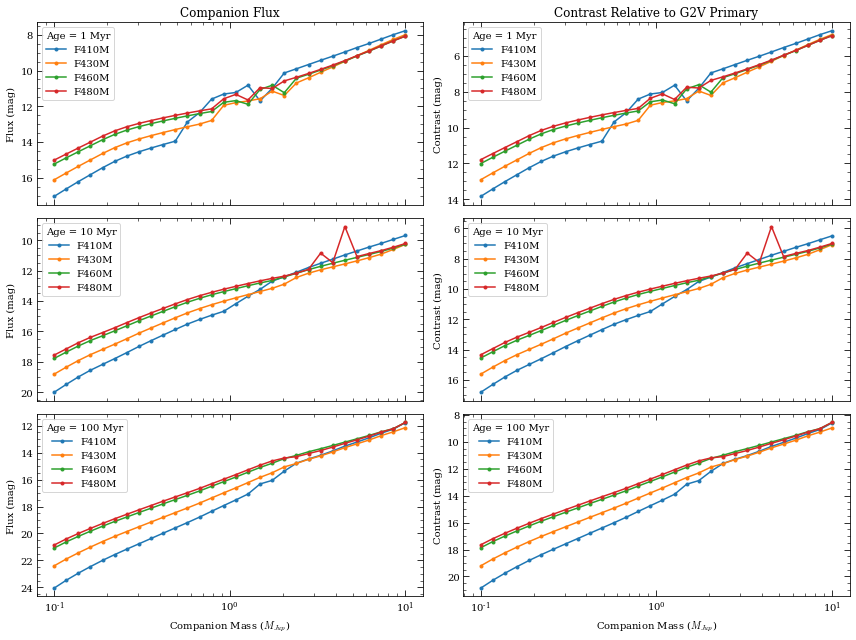

In [129]:
fig, axes_all = plt.subplots(3,2,figsize=(12,9),sharex=True)

ages = [1, 10, 100] # Myr
masses = 10**np.linspace(-1,1,num=30) # MJup
filters = ['F410M', 'F430M', 'F460M', 'F480M']

# Normalize a G2V star to it's K-Band absolute magnitude
spt = 'G2V'
sp_star = pynrc.stellar_spectrum(spt, 3.2, 'vegamag', bp_k)

for i, age in enumerate(ages):
    axes = axes_all[i]
    
    for filt in filters:
        bp = nrc_utils.read_filter(filt, module='B')
        res = get_planet_counts(bp, age, masses, return_mags=True)    
        axes[0].semilogx(masses, res, marker='.', label=filt)

        obs = S.Observation(sp_star, bp, bp.wave)
        axes[1].semilogx(masses, res - obs.effstim('vegamag'), marker='.', label=filt)

    axes[0].set_ylabel("Flux (mag)")
    axes[1].set_ylabel("Contrast (mag)")
    if i==0: 
        axes[0].set_title(f"Companion Flux")
        axes[1].set_title(f"Contrast Relative to {spt} Primary")

    
    for ax in axes:
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.legend(title=f'Age = {age} Myr')
        if i==2: 
            ax.set_xlabel('Companion Mass ($M_{Jup}$)')
    
fig.tight_layout()

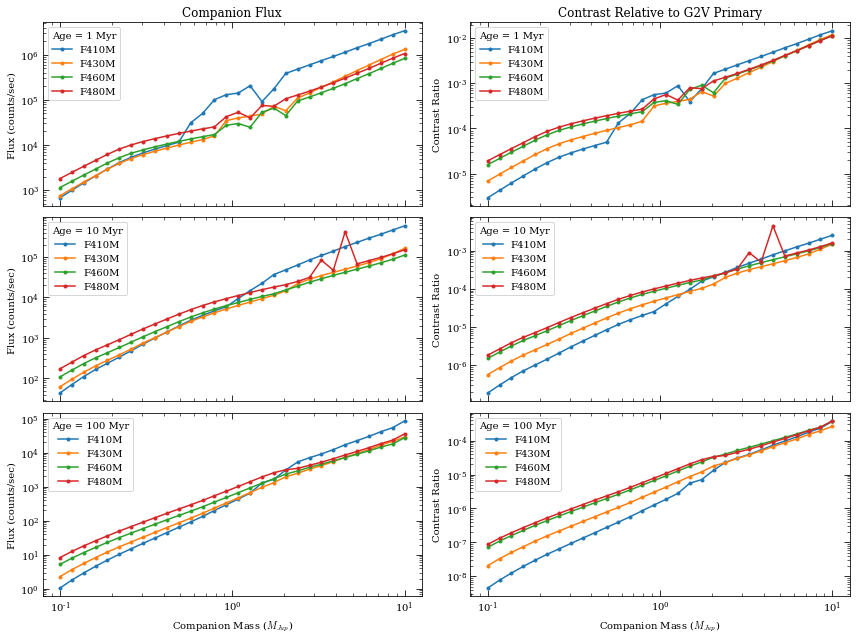

In [125]:
fig, axes_all = plt.subplots(3,2,figsize=(12,9),sharex=True)

ages = [1, 10, 100] # Myr
masses = 10**np.linspace(-1,1,num=30) # MJup
filters = ['F410M', 'F430M', 'F460M', 'F480M']

# Normalize a G2V star to it's K-Band absolute magnitude
spt = 'G2V'
sp_star = pynrc.stellar_spectrum(spt, 3.2, 'vegamag', bp_k)

for i, age in enumerate(ages):
    axes = axes_all[i]
    
    for filt in filters:
        bp = nrc_utils.read_filter(filt, module='B')
        res = get_planet_counts(bp, age, masses)    
        axes[0].loglog(masses, res, marker='.', label=filt)

        obs = S.Observation(sp_star, bp, bp.wave)
        axes[1].loglog(masses, res / obs.countrate(), marker='.', label=filt)

    axes[0].set_ylabel("Flux (counts/sec)")
    axes[1].set_ylabel("Contrast Ratio")
    if i==0: 
        axes[0].set_title(f"Companion Flux")
        axes[1].set_title(f"Contrast Relative to {spt} Primary")

    
    for ax in axes:
        ax.legend(title=f'Age = {age} Myr')
        if i==2: 
            ax.set_xlabel('Companion Mass ($M_{Jup}$)')
    
fig.tight_layout()

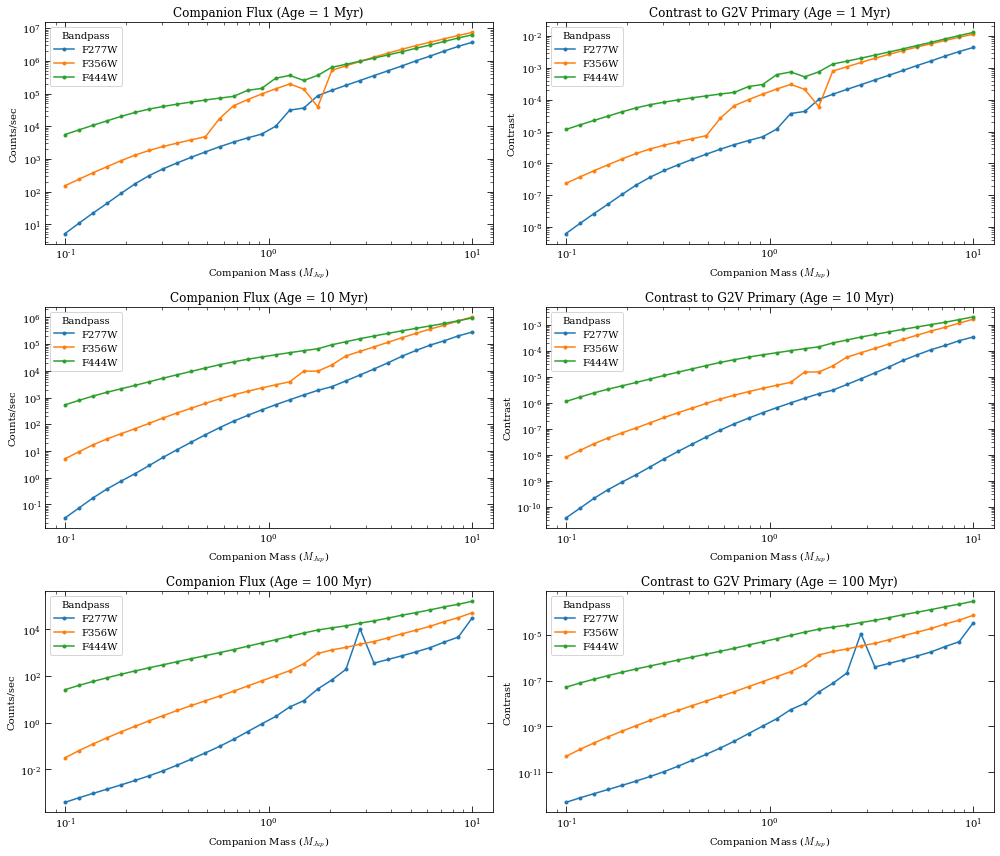

In [109]:
fig, axes_all = plt.subplots(3,2,figsize=(14,12))

ages = [1, 10, 100] # Myr
masses = 10**np.linspace(-1,1,num=30) # MJup
filters = ['F277W', 'F356W', 'F444W']

# Normalize a G2V star to it's K-Band absolute magnitude
spt = 'G2V'
sp_star = pynrc.stellar_spectrum(spt, 3.2, 'vegamag', bp_k)

for i, age in enumerate(ages):
    axes = axes_all[i]
    
    for filt in filters:
        bp = nrc_utils.read_filter(filt, module='B')#, pupil='CIRCLYOT', mask='MASK335R')
        res = get_planet_counts(bp, age, masses)    
        axes[0].loglog(masses, res, marker='.', label=filt)

        obs = S.Observation(sp_star, bp, bp.wave)
        axes[1].loglog(masses, res / obs.countrate(), marker='.', label=filt)

    ax = axes[0]
    ax.set_ylabel("Counts/sec")
    ax.set_title(f"Companion Flux (Age = {age} Myr)")
    ax = axes[1]
    ax.set_ylabel("Contrast")
    ax.set_title(f"Contrast to {spt} Primary (Age = {age} Myr)")

    for ax in axes:
        ax.legend(title='Bandpass')
        ax.set_xlabel('Companion Mass ($M_{Jup}$)')
    
fig.tight_layout()